In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mainData = 'P_Economic Indicators.xlsx'

In [3]:
def dataInitialization(data):

    #Read the main Dataset file
    dfData = pd.read_excel(data)
    dfCountryMetaData = pd.read_excel(data, sheet_name = 'Country - Metadata')
    dfSeriesMetaData = pd.read_excel(data, sheet_name = 'Series - Metadata')

    #Change column name from 'Code' in Metadata sheets for merging
    dfCountryMetaData.rename( columns = {'Code':'Country Code'}, inplace = True)
    dfSeriesMetaData.rename( columns = {'Code':'Series Code'}, inplace = True)

    #Merged columns from Data and Country MetaData
    dfMerged = pd.merge(dfData, dfCountryMetaData[['Country Code', 'Region','Income Group']], on = 'Country Code', how = 'left')

    #Sorting Columns out, changing column positions to start of df
    columns = dfMerged.columns.to_list()
    columns.insert(2, columns.pop(dfMerged.columns.get_loc('Region')))
    columns.insert(3, columns.pop(dfMerged.columns.get_loc('Income Group')))
    dfMerged = dfMerged[columns]

    #Setting Multilevel Index for df (dfCountry)
    dfCountry = dfMerged.set_index(['Country Name', 'Country Code', 'Region', 'Income Group', 'Series Name', 'Series Code'])

    # dfCountry = dfCountry.loc[pd.IndexSlice[:, ('CHN', 'USA', 'DEU', 'GBR', 'IND', 'PAK', 'BGD'), :, :, :, :] , :]
    
    dfCountry = dfCountry.loc[pd.IndexSlice[ :, :, :, ('Upper middle income', 'Lower middle income', 'High income', 'Low income'), :, :] , :]

    #Renaming all columns to have only first 4 letters 
    dfCountry.columns = list(map(lambda c: c[:4], dfCountry.columns))
     
    #Delete last 5 rows from the dataframe 
    dfCountry = dfCountry.iloc[:-5]

    return dfCountry

In [4]:
finalData = dataInitialization(mainData)

In [5]:
GDPSeries = finalData.loc[pd.IndexSlice[:, :, :, :, :, ('NY.GDP.MKTP.CD')] , :]

giniSeries = finalData.loc[pd.IndexSlice[:, :, :, :, :, ('SI.POV.GINI')] , :]

employmentSeries = finalData.loc[pd.IndexSlice[:, :, :, :, :, ('SM.POP.NETM', 'SL.UEM.ADVN.ZS', 'SL.UEM.TOTL.NE.ZS')] , :]

povertySeries = finalData.loc[pd.IndexSlice[:, :, :, :, :, ('SI.DST.50MD')] , :]

tradeSeries = finalData.loc[pd.IndexSlice[:, :, :, :, :, ('BN.GSR.GNFS.CD')] , :]

In [6]:
GDPSeries.reset_index(inplace = True)
giniSeries.reset_index(inplace = True)
employmentSeries.reset_index(inplace = True)
povertySeries.reset_index(inplace = True)
tradeSeries.reset_index(inplace = True)

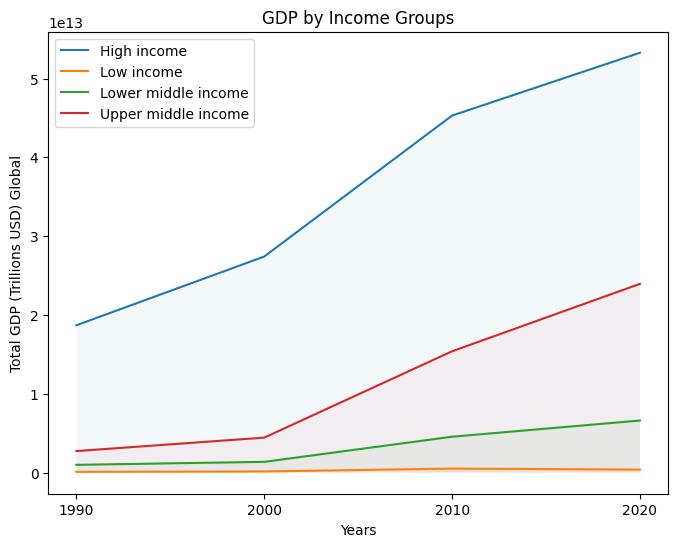

In [7]:
dfgdp = pd.melt(GDPSeries, id_vars = ['Country Name', 'Series Name', 'Income Group'], value_vars = [str(x) for x in range(1990, 2021, 10)])
dfgdp['value'] = pd.to_numeric(dfgdp['value'], errors='coerce')
gdpGroup = dfgdp.groupby(['Income Group', 'variable'])['value'].sum().reset_index()
gdpPivot = gdpGroup.pivot_table(index = 'Income Group', columns = 'variable', values = 'value')

plt.figure(figsize = (8, 6))

line_data = gdpPivot.transpose()

# line_data = line_data.astype(float)

for country in line_data.columns:
    plt.plot(line_data.index, line_data[country], label=country)
    plt.fill_between(line_data.index, line_data[country], alpha = 0.05)

plt.xlabel('Years')
plt.ylabel('Total GDP (Trillions USD) Global')
plt.title('GDP by Income Groups')
plt.legend() 

plt.show()

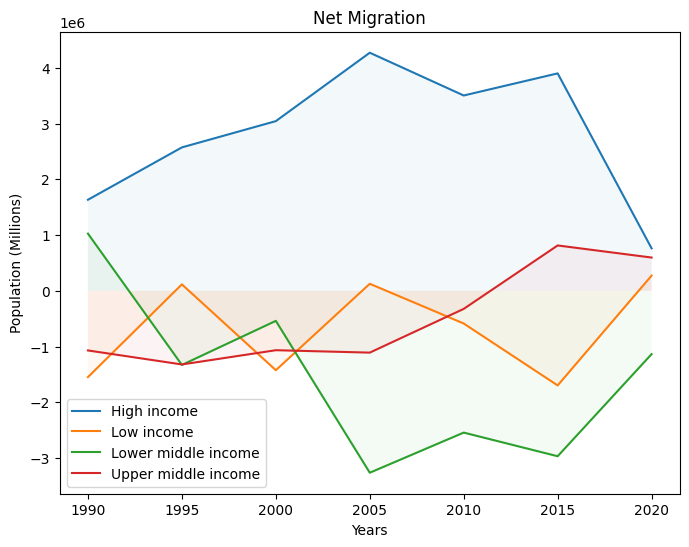

In [8]:
dfemployment = pd.melt(employmentSeries, id_vars = ['Country Name', 'Series Name', 'Income Group'], value_vars = [str(x) for x in range(1990, 2021, 5)])
dfemployment = dfemployment[dfemployment['Series Name'].isin(['Net migration'])]
dfemployment['value'] = pd.to_numeric(dfemployment['value'], errors='coerce')
empGroup = dfemployment.groupby(['Income Group', 'variable'])['value'].sum().reset_index()
empPivot = empGroup.pivot_table(index = 'Income Group', columns = 'variable', values = 'value')

plt.figure(figsize = (8, 6))

line1_data = empPivot.transpose()
for country in line1_data.columns:
    plt.plot(line1_data.index, line1_data[country], label=country)
    plt.fill_between(line1_data.index, line1_data[country], alpha = 0.05)

plt.xlabel('Years')
plt.ylabel('Population (Millions)')
plt.title('Net Migration')
plt.legend() 

plt.show()


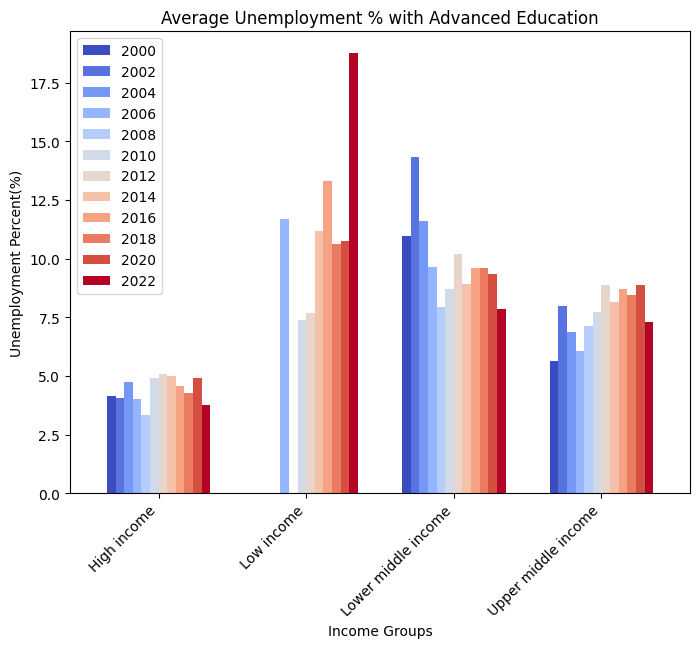

In [9]:
dfunEmp = pd.melt(employmentSeries, id_vars = ['Country Name', 'Country Code', 'Series Name', 'Income Group'], value_vars = [str(x) for x in range(2000, 2023, 2)])
dfunEmp = dfunEmp[dfunEmp['Series Name'].isin(['Unemployment with advanced education (% of total labor force with advanced education)'])]
dfunEmp['value'] = pd.to_numeric(dfunEmp['value'], errors='coerce')
unEmpGroup = dfunEmp.groupby(['Income Group', 'variable'])['value'].mean().reset_index()
unEmpPivot = unEmpGroup.pivot_table(index = 'Income Group', columns = 'variable', values = 'value').plot(kind = 'bar', width = 0.7, figsize = (8, 6), colormap = 'coolwarm')

plt.xlabel('Income Groups')
plt.ylabel('Unemployment Percent(%)')
plt.title('Average Unemployment % with Advanced Education')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()
plt.show()

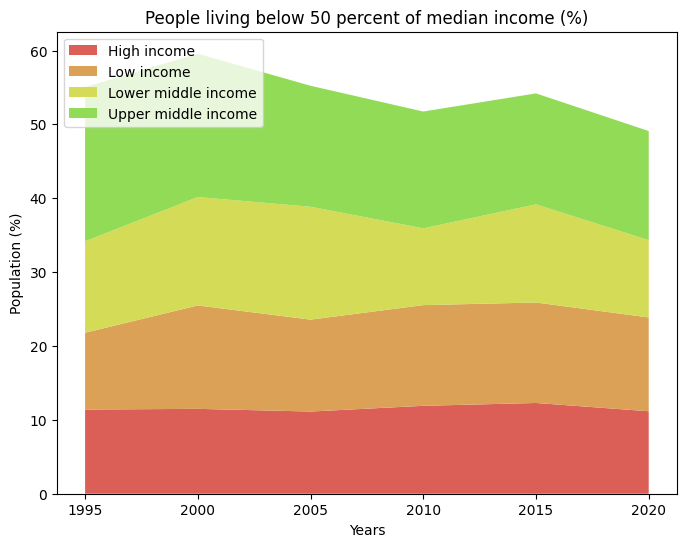

In [10]:

dfpoverty = pd.melt(povertySeries, id_vars = ['Country Name', 'Country Code', 'Series Name', 'Income Group'], value_vars = [str(x) for x in range(1995, 2023, 5)])
dfpoverty['value'] = pd.to_numeric(dfpoverty['value'], errors='coerce')
povGroup = dfpoverty.groupby(['Income Group', 'variable'])['value'].mean().reset_index()
povPivot = povGroup.pivot_table(index = 'Income Group', columns = 'variable', values = 'value')

plt.figure(figsize = (8, 6))

years = povPivot.columns
values = povPivot.values

pallete = sns.color_palette('hls', 12)

plt.stackplot(years, values, labels = povPivot.index, colors = pallete)

plt.xlabel('Years')
plt.ylabel('Population (%)')
plt.title('People living below 50 percent of median income (%)')
plt.legend(loc = 'upper left')

plt.show()